# Explainability

To run the notebook we recommend running the cells until the clustering section, and then going to the section of explainability you want to see the results of. 

**Note**: The notebook was already run with the NN results.

**Note**: for DiCE, as it required older versions of library we had installed in our environment, we created a separated requirements_dice.txt. To run the dice experiments, execute the cells until clustering (excluded) and then go to the DiCE section and run everything.

**Note**: to run the experiments for random forest you need to change the vale of variable MODEL_NAME. Do note that we do not include in the repo the model as it weights too much (2GB)

In [26]:
import joblib
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from copy import deepcopy


os.environ["KERAS_BACKEND"] = "torch"
import keras
from matplotlib import pyplot as plt

In [27]:
MODELS_DIR = "models" + os.sep
MODEL_NAME = "best_nn.pkl"  # "best_rf.pkl"
DATASET_DIR = "dataset" + os.sep
TRAIN_NAME = "train_set.csv"
TEST_NAME = "test_set.csv"
PREPROCESSING_NAME = "nn_preprocessor.pkl"

In [28]:
model = joblib.load(MODELS_DIR + MODEL_NAME)

train_df = pd.read_csv(DATASET_DIR + TRAIN_NAME)
test_df = pd.read_csv(DATASET_DIR + TEST_NAME)
y_train = train_df.pop("position")
X_train = train_df
y_test = test_df.pop("position")
X_test = test_df
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((554288, 11), (554288,), (35406, 11), (35406,))

In [29]:
X_train["season"] = X_train["season"].astype("category")
X_test["season"] = X_train["season"].astype("category")
X_train["continent"] = X_train["continent"].astype("category")
X_test["continent"] = X_train["continent"].astype("category")

# obtain mapping from category to integer
season_mapping = dict(enumerate(X_train["season"].cat.categories))
continent_mapping = dict(enumerate(X_train["continent"].cat.categories))

# use codes to replace category
X_train["season"] = X_train["season"].cat.codes
X_test["season"] = X_test["season"].cat.codes
X_train["continent"] = X_train["continent"].cat.codes
X_test["continent"] = X_test["continent"].cat.codes

full_dataset = pd.concat([X_train, X_test])

profile_mapping = {
    "nan": "nan",
    "0.0": "nan",
    "1.0": "flat",
    "2.0": "hilly",
    "3.0": "mountainous",
    "4.0": "high mountains",
    "5.0": "uphill finish",
}

print(season_mapping)
print(continent_mapping)
print(profile_mapping)

{0: 'Fall', 1: 'Spring', 2: 'Summer', 3: 'Winter'}
{0: 'Africa', 1: 'Asia', 2: 'Europe', 3: 'North America', 4: 'Oceania', 5: 'South America'}
{'nan': 'nan', '0.0': 'nan', '1.0': 'flat', '2.0': 'hilly', '3.0': 'mountainous', '4.0': 'high mountains', '5.0': 'uphill finish'}


In [30]:
classifier = model[-1]
model

Pipeline(steps=[('imputation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('general',
                                                  SimpleImputer(strategy='median'),
                                                  ['cyclist_age', 'height',
                                                   'weight']),
                                                 ('profile',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['profile'])],
                                   verbose_feature_names_out=False)),
                ('bmi', BMICalculatorTransformer()),
                ('remove',
                 ColumnRemoverTransformer(columns=...
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['points', 'BMI',
                                                   'cyclist_age', 'length',
                                                   'startlist_quality']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['profile', 'season',
                                                   'continent'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 SklearnKerasClassifier(model=<Sequential name=sequential, built=True>))])

In [31]:
original_pipeline = deepcopy(model)

# telling one hot encoder to output pandas df and not numpy array
model[-2].set_output(transform="pandas")
model[-2]["onehot"].set_params(sparse_output=False)

# obtain dataset after one hot encoding
X_train_transformed = model[:-1].transform(X_train)
X_test_transformed = model[:-1].transform(X_test)

# obtain dataset before one hot encoding
X_test_pre_ohe = model[:-2].transform(X_test)
X_train_pre_ohe = model[:-2].transform(X_train)

### Clutering (only needed if you want to run all experiments)

In [7]:
X_train_stratify = X_train_transformed.copy()
X_test_stratify = X_test_transformed.copy()

# using also position to cluster
X_train_stratify["position"] = y_train
X_test_stratify["position"] = y_test

categorical_columns = ["season", "continent", "profile", "position"]

## when using trees, we do not standardize, so we have to standardize before clustering
if "rf" in MODEL_NAME or "xgb" in MODEL_NAME:

    # load best_nn.pkl
    best_nn = joblib.load(MODELS_DIR + "best_nn.pkl")
    best_nn[-2].set_output(transform="pandas")

    X_train_stratify[
        ["points", "BMI", "cyclist_age", "length", "startlist_quality"]
    ] = best_nn[-2]["scaler"].transform(
        X_train_stratify[
            ["points", "BMI", "cyclist_age", "length", "startlist_quality"]
        ]
    )
    X_test_stratify[
        ["points", "BMI", "cyclist_age", "length", "startlist_quality"]
    ] = best_nn[-2]["scaler"].transform(
        X_test_stratify[["points", "BMI", "cyclist_age", "length", "startlist_quality"]]
    )


# kmeans clustering, data already one hot encoded and standardized
from sklearn.cluster import KMeans

# For X_train
kmeans = KMeans(n_clusters=1000, random_state=42)
kmeans.fit_predict(X_train_stratify.dropna())
centroids = kmeans.cluster_centers_

# for each centroid, obtain the closest data point
closest_points = []
for centroid in centroids:
    closest_points.append(
        np.argmin(np.linalg.norm(X_train_stratify.dropna() - centroid, axis=1))
    )

# now that we have index of closest points, we can obtain the actual data points
X_train_stratify = X_train_stratify.dropna().iloc[closest_points].reset_index(drop=True)
X_train_pre_ohe_stratify = X_train_pre_ohe.iloc[closest_points].reset_index(drop=True)
X_train_transformed_stratify = X_train_transformed.iloc[closest_points].reset_index(
    drop=True
)
y_train_stratify = X_train_stratify["position"].reset_index(drop=True)

# Clustering for X_test
kmeans_test = KMeans(n_clusters=1000, random_state=42)
kmeans_test.fit_predict(X_test_stratify.dropna())
centroids_test = kmeans_test.cluster_centers_

# for each centroid, obtain the closest data point
closest_points_test = []
for centroid in centroids_test:
    closest_points_test.append(
        np.argmin(np.linalg.norm(X_test_stratify.dropna() - centroid, axis=1))
    )

# now that we have index of closest points, we can obtain the actual data points
X_test_stratify = (
    X_test_stratify.dropna().iloc[closest_points_test].reset_index(drop=True)
)
X_test_pre_ohe_stratify = (
    X_test_pre_ohe.dropna().iloc[closest_points_test].reset_index(drop=True)
)
X_test_transformed_stratify = (
    X_test_transformed.dropna().iloc[closest_points_test].reset_index(drop=True)
)
y_test_stratify = X_test_stratify["position"].reset_index(drop=True)

# check shapes
X_train_pre_ohe_stratify.shape, y_train_stratify.shape, X_test_pre_ohe_stratify.shape, y_test_stratify.shape

((1000, 8), (1000,), (1000, 8), (1000,))

In [8]:
# selecting only 100 samples from the clustered data
from sklearn.model_selection import train_test_split

# Fix the seed for reproducibility
random_state = 0

# Split the data and assign to new variables
X_train_stratify, _, y_train_stratify_new, _ = train_test_split(
    X_train_stratify,
    y_train_stratify,
    test_size=0.9,
    stratify=y_train_stratify,
    random_state=random_state,
)

X_test_stratify, _, y_test_stratify_new, _ = train_test_split(
    X_test_stratify,
    y_test_stratify,
    test_size=0.9,
    stratify=y_test_stratify,
    random_state=random_state,
)

X_train_pre_ohe_stratify, _, y_train_stratify_new_2, _ = train_test_split(
    X_train_pre_ohe_stratify,
    y_train_stratify,
    test_size=0.9,
    stratify=y_train_stratify,
    random_state=random_state,
)

X_test_pre_ohe_stratify, _, y_test_stratify_new_2, _ = train_test_split(
    X_test_pre_ohe_stratify,
    y_test_stratify,
    test_size=0.9,
    stratify=y_test_stratify,
    random_state=random_state,
)

X_train_transformed_stratify, _, y_train_stratify_new_3, _ = train_test_split(
    X_train_transformed_stratify,
    y_train_stratify,
    test_size=0.9,
    stratify=y_train_stratify,
    random_state=random_state,
)

X_test_transformed_stratify, _, y_test_stratify_new_3, _ = train_test_split(
    X_test_transformed_stratify,
    y_test_stratify,
    test_size=0.9,
    stratify=y_test_stratify,
    random_state=random_state,
)

# Assert if the vectors of labels are all the same (i.e. splits are the same)
assert y_train_stratify_new.equals(y_train_stratify_new_2)
assert y_train_stratify_new.equals(y_train_stratify_new_3)
assert y_test_stratify_new.equals(y_test_stratify_new_2)
assert y_test_stratify_new.equals(y_test_stratify_new_3)

# Assign the new labels back to the original variables
y_train_stratify = y_train_stratify_new
y_test_stratify = y_test_stratify_new


# print value counts
print(y_train_stratify.value_counts(), y_test_stratify.value_counts())

# check shapes
X_train_pre_ohe_stratify.shape, y_train_stratify.shape, X_test_pre_ohe_stratify.shape, y_test_stratify.shape

position
0    87
1    13
Name: count, dtype: int64 position
0    86
1    14
Name: count, dtype: int64


((100, 8), (100,), (100, 8), (100,))

In [10]:
from sklearn.metrics import fbeta_score

y_pred = classifier.predict(X_test_transformed.values)
if "keras" in MODEL_NAME or "nn" in MODEL_NAME:
    y_pred = (y_pred > 0.5).astype(int)

validation_report = classification_report(
    y_test,
    y_pred,
    target_names=["non top-20", "top-20"],
    output_dict=True,
)
validation_df = pd.DataFrame(validation_report)

# manually doing the report for fbeta 0.5
fbeta = fbeta_score(y_test, y_pred, beta=0.5, average=None)
validation_df.loc["fbeta_0.5"] = [
    fbeta[0],
    fbeta[1],
    validation_report["accuracy"],
    np.nan,
    np.nan,
]
fbeta_weighted = fbeta_score(y_test, y_pred, beta=0.5, average="weighted")
fbeta_macro = fbeta_score(y_test, y_pred, beta=0.5, average="macro")
validation_df.loc["fbeta_0.5", "weighted avg"] = fbeta_weighted
validation_df.loc["fbeta_0.5", "macro avg"] = fbeta_macro
validation_df

non top-20       top-20  accuracy     macro avg  weighted avg
precision      0.886754     0.206689  0.695504      0.546721      0.791868
recall         0.740727     0.416599  0.695504      0.578663      0.695504
f1-score       0.807189     0.276297  0.695504      0.541743      0.733117
support    30466.000000  4940.000000  0.695504  35406.000000  35406.000000
fbeta_0.5      0.853117     0.229852  0.695504      0.541484      0.766157

In [11]:
# evaluating model on stratified test set
y_pred_stratify = classifier.predict(X_test_transformed_stratify.values)

if "keras" in MODEL_NAME:
    y_pred_stratify = (y_pred_stratify > 0.5).astype(int)

validation_report_stratify = classification_report(
    y_test_stratify,
    y_pred_stratify,
    target_names=["non top-20", "top-20"],
    output_dict=True,
)
validation_df_stratify = pd.DataFrame(validation_report_stratify)

# manually doing the report for fbeta 0.5
fbeta_stratify = fbeta_score(y_test_stratify, y_pred_stratify, beta=0.5, average=None)
fbeta_weighted_stratify = fbeta_score(
    y_test_stratify, y_pred_stratify, beta=0.5, average="weighted"
)
fbeta_macro_stratify = fbeta_score(
    y_test_stratify, y_pred_stratify, beta=0.5, average="macro"
)

validation_df_stratify.loc["fbeta_0.5"] = [
    fbeta_stratify[0],
    fbeta_stratify[1],
    validation_report_stratify["accuracy"],
    fbeta_macro_stratify,
    fbeta_weighted_stratify,
]
print(y_test_stratify.value_counts())
validation_df_stratify

position
0    86
1    14
Name: count, dtype: int64


non top-20     top-20  accuracy   macro avg  weighted avg
precision    0.875000   0.166667      0.62    0.520833      0.775833
recall       0.651163   0.428571      0.62    0.539867      0.620000
f1-score     0.746667   0.240000      0.62    0.493333      0.675733
support     86.000000  14.000000      0.62  100.000000    100.000000
fbeta_0.5    0.818713   0.189873      0.62    0.504293      0.730676

## SHAP

In [12]:
import shap
from shap._explanation import group_features

shap.initjs()

### Run experiments (skip execution if only want to see results)

In [17]:
explainer = shap.KernelExplainer(
    classifier.predict_proba, X_train_transformed_stratify, link="logit"
)

In [19]:
# X_test_transformed_stratify = np.delete(X_test_transformed_stratify, 58, axis=0)
int_expl = explainer(X_test_transformed_stratify)

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
# save explanations in results folder
# joblib.dump(int_expl, f"results{os.sep}shap_{MODEL_NAME}.pkl")

['results/shap_best_nn.pkl.pkl']

### See results

In [21]:
# load explanations
int_expl = joblib.load(f"results{os.sep}shap_{MODEL_NAME}.pkl")

In [23]:
# remove standardization from X_test_transformed_stratify for the plots
if "nn" in MODEL_NAME:
    old_test_strat = X_test_transformed_stratify.copy()
    X_test_transformed_stratify[
        ["points", "BMI", "cyclist_age", "length", "startlist_quality"]
    ] = model[-2]["scaler"].inverse_transform(
        X_test_transformed_stratify[
            ["points", "BMI", "cyclist_age", "length", "startlist_quality"]
        ]
    )
    int_expl.data = X_test_transformed_stratify.values

In [24]:
# Group one hot encoded explanations

feature_map = {
    col: "season" for col in X_train_transformed.columns if col.startswith("season_")
}
feature_map.update(
    {
        col: "continent"
        for col in X_train_transformed.columns
        if col.startswith("continent_")
    }
)
feature_map.update(
    {
        col: "profile"
        for col in X_train_transformed.columns
        if col.startswith("profile_")
    }
)

grouped_expl = group_features(int_expl, feature_map)

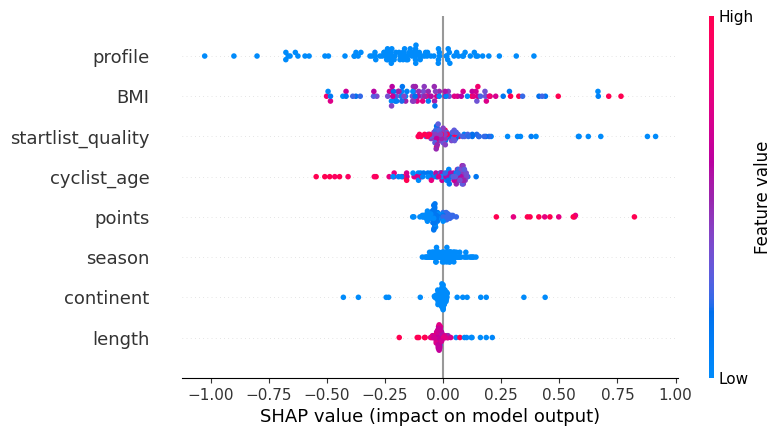

In [25]:
shap.plots.beeswarm(grouped_expl[:, :, 1], max_display=25)

In [26]:
shap.plots.force(int_expl[:, :, 1])

In [27]:
# change feature names of explanation using profile mapping

int_expl.feature_names = [
    (
        "profile_" + profile_mapping[x.split("_")[1]]
        if x.startswith("profile") and len(x.split("_")) > 1
        else x
    )
    for x in int_expl.feature_names
]
int_expl.feature_names

['points',
 'BMI',
 'cyclist_age',
 'length',
 'startlist_quality',
 'profile_nan',
 'profile_flat',
 'profile_hilly',
 'profile_mountainous',
 'profile_high mountains',
 'profile_uphill finish',
 'season_0',
 'season_1',
 'season_2',
 'season_3',
 'continent_0',
 'continent_1',
 'continent_2',
 'continent_3',
 'continent_4',
 'continent_5']

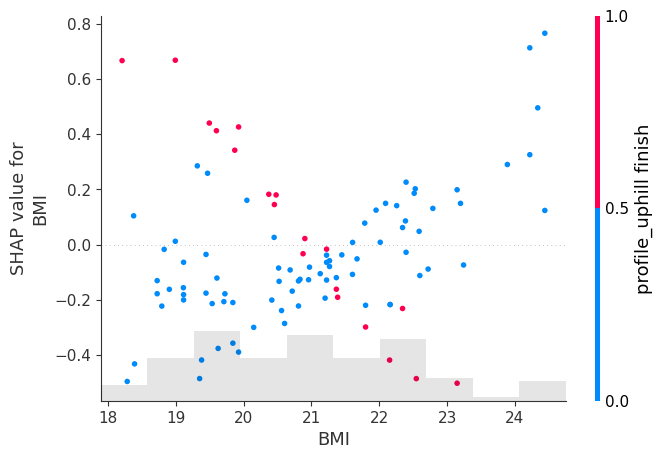

In [29]:
shap.plots.scatter(int_expl[:, "BMI", 1], color=int_expl[:, "profile_uphill finish", 1])

## LIME

In [30]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret import show
from tqdm import tqdm
from interpret.blackbox import LimeTabular
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import classification_report

set_visualize_provider(InlineProvider())

In [31]:
categorical_columns = ["season", "continent", "profile"]
categorical_feature_indices = [
    X_train_pre_ohe.columns.get_loc(col) for col in categorical_columns
]
categorical_feature_indices

[6, 7, 1]

In [32]:
def f(X):
    return original_pipeline[-2:].predict_proba(X)

In [33]:
# create lime explainer
explainer = LimeTabularExplainer(
    X_train_pre_ohe.values,
    mode="classification",
    feature_names=X_train_pre_ohe.columns,
    categorical_features=categorical_feature_indices,
    categorical_names={
        "season": ["Fall", "Spring", "Summer", "Winter"],
        "continent": [
            "Africa",
            "Asia",
            "Europe",
            "North America",
            "Oceania",
            "South America",
        ],
        "profile": [
            "flat",
            "hilly",
            "mountainous",
            "high mountains",
            "uphill finish",
        ],
    },
    class_names=["non top-20", "top-20"],
)

explanations = dict()

# explain each instance in the test set
for i in tqdm(range(X_test_pre_ohe_stratify.shape[0])):
    explanation = explainer.explain_instance(
        X_test_pre_ohe_stratify.values[i],
        lambda x: f(pd.DataFrame(x, columns=X_test_pre_ohe.columns)),
        num_features=4,
        top_labels=1,
        num_samples=5000,
    )
    explanations[i] = explanation

100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


In [34]:
# compute model prediction on X_test_pre_ohe_stratify
y_pred = original_pipeline[-2:].predict(X_test_pre_ohe_stratify)

if "nn" in MODEL_NAME:
    y_pred = (y_pred > 0.5).astype(int)
    y_pred = pd.Series(y_pred.flatten(), index=y_test_stratify.index)

print(classification_report(y_test_stratify, y_pred))


# obtaining indices of true positives, false positives, false negatives and true negatives
true_positives = np.argwhere((y_pred == 1) & (y_test_stratify == 1)).squeeze(axis=1)
false_positives = np.argwhere((y_pred == 1) & (y_test_stratify == 0)).squeeze(axis=1)
false_negatives = np.argwhere((y_pred == 0) & (y_test_stratify == 1)).squeeze(axis=1)
true_negatives = np.argwhere((y_pred == 0) & (y_test_stratify == 0)).squeeze(axis=1)

              precision    recall  f1-score   support

           0       0.88      0.65      0.75        86
           1       0.17      0.43      0.24        14

    accuracy                           0.62       100
   macro avg       0.52      0.54      0.49       100
weighted avg       0.78      0.62      0.68       100



In [35]:
# plot the explanations
for idx in true_positives[:5]:
    print(f"Instance {idx} predicted class: {explanations[idx].predict_proba.argmax()}")
    explanations[idx].show_in_notebook()

Instance 9 predicted class: 1


Instance 19 predicted class: 1


Instance 41 predicted class: 1


Instance 63 predicted class: 1


Instance 75 predicted class: 1


In [36]:
# save explanations
joblib.dump(explanations, f"results{os.sep}lime_{MODEL_NAME}.pkl")

['results/lime_best_nn.pkl.pkl']

## LORE

In [7]:
from xailib.explainers.lore_explainer import (
    LoreTabularExplainer,
    LOREM,
    prepare_dataset,
    LoreTabularExplanation,
)
import xailib.explainers.lore_explainer as lore
from tqdm import tqdm
from libraries.explain import (
    rescale_rule,
    translate_rule,
    rescale_rule_cf,
    translate_rule_cf,
)

### Run the experiments (skip execution if only want to see results)

In [38]:
y_pred = classifier.predict(X_test_transformed_stratify)

y_test_small = y_test_stratify

print(classification_report(y_test_small, y_pred))

# make y_pred a pandas series
y_pred = pd.Series(y_pred.reshape(y_pred.shape[0]), index=y_test_small.index)

# obtaining indices of true positives, false positives, false negatives and true negatives
true_positives = np.argwhere((y_pred == 1) & (y_test_small == 1)).squeeze(axis=1)
false_positives = np.argwhere((y_pred == 1) & (y_test_small == 0)).squeeze(axis=1)
false_negatives = np.argwhere((y_pred == 0) & (y_test_small == 1)).squeeze(axis=1)
true_negatives = np.argwhere((y_pred == 0) & (y_test_small == 0)).squeeze(axis=1)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.14      1.00      0.25        14

    accuracy                           0.14       100
   macro avg       0.07      0.50      0.12       100
weighted avg       0.02      0.14      0.03       100



In [39]:
explainer_lore = LoreTabularExplainer(original_pipeline[-1])
configuration = {"neigh_type": "rndgen", "size": 100, "ocr": 0.1, "ngen": 10}

lore_train_data = pd.concat((X_train_transformed, y_train), axis=1)
explainer_lore.fit(
    lore_train_data,
    "position",
    config=configuration,
)

In [40]:
explanations_lore = {
    "False negatives": [],
    "False positives": [],
    "True positives": [],
    "True negatives": [],
}

In [41]:
for idx in tqdm(true_positives[:5]):
    print(f"Instance {idx} ")
    X_test_transformed.loc[idx]
    explanations_lore["True positives"].append(
        (
            idx,
            explainer_lore.explain(X_test_transformed.loc[idx].values),
        )
    )
    # print(f"Instance {idx} predicted class: {explanation.predicted_class}")

  0%|          | 0/5 [00:00<?, ?it/s]

Instance 1 


 20%|██        | 1/5 [00:32<02:11, 32.88s/it]

Instance 6 


 40%|████      | 2/5 [01:06<01:40, 33.51s/it]

Instance 9 


 60%|██████    | 3/5 [01:37<01:04, 32.08s/it]

Instance 19 


 80%|████████  | 4/5 [02:09<00:31, 31.97s/it]

Instance 41 


100%|██████████| 5/5 [02:39<00:00, 31.84s/it]


In [35]:
# commented to not overwrite the results accidentally
# joblib.dump(explanations_lore, f"results{os.sep}lore_{MODEL_NAME}.pkl")

['results/lore_best_nn.pkl.pkl']

### Results LORE

In [16]:
explanations_lore_nn = joblib.load(f"results{os.sep}lore_best_nn.pkl.pkl")
explanations_lore_rf = joblib.load(f"results{os.sep}lore_best_rf.pkl.pkl")

In [17]:
scaled_cols = ["points", "BMI", "cyclist_age", "length", "startlist_quality"]
means = model[-2]["scaler"].mean_
stds = model[-2]["scaler"].scale_

In [18]:
for key, values in explanations_lore_nn.items():
    for idx, explanation in values:
        rules = explanation.getRules()
        rescaled_rules = rescale_rule(rules, means, stds)
        final_rules = translate_rule(rescaled_rules)
        explanation.expDict["rule"] = final_rules

for key, values in explanations_lore_rf.items():
    for idx, explanation in values:
        rules = explanation.getRules()
        final_rules = translate_rule(rules)
        explanation.expDict["rule"] = final_rules

In [19]:
for key, values in explanations_lore_nn.items():
    print(key)
    for idx, explanation in values:
        if idx in [4917, 29776]:
            print(idx)
            explanation.plotRules()

False negatives
False positives
True positives
29776


True negatives
4917


In [20]:
for key, values in explanations_lore_rf.items():
    print(key)
    for idx, explanation in values:
        if idx in [31, 23]:
            print(idx)
            explanation.plotRules()

False negatives
23


False positives
31


True positives
True negatives


In [21]:
for key, values in explanations_lore_nn.items():
    for idx, explanation in values:
        crules = explanation.getCounterfactualRules()
        rescaled_crules = rescale_rule_cf(crules, means, stds)
        final_crules = translate_rule_cf(rescaled_crules)
        explanation.expDict["crule"] = final_crules

for key, values in explanations_lore_rf.items():
    for idx, explanation in values:
        crules = explanation.getCounterfactualRules()
        final_crules = translate_rule_cf(crules)
        explanation.expDict["crule"] = final_crules

In [22]:
considered_samples = X_test_pre_ohe.loc[[4917, 29776]]
# add column classified, where it tels if the rf classified it as fp or fn. 4917 is fp, the other is fn
considered_samples["classified"] = ["fp", "fn"]
considered_samples["continent"] = considered_samples["continent"].map(continent_mapping)
considered_samples["season"] = considered_samples["season"].map(season_mapping)
considered_samples["profile"] = considered_samples["profile"].map(
    lambda x: profile_mapping[str(x)]
)
considered_samples.reset_index(drop=True)

cyclist_age        profile  points    length  startlist_quality        BMI  \
0         27.0          hilly      50  169400.0                981  20.971172   
1         31.0  uphill finish     100  144900.0               1584  19.379197   

   season continent classified  
0  Summer    Europe         fp  
1  Summer    Europe         fn

In [23]:
for key, values in explanations_lore_nn.items():
    print(key)
    for idx, explanation in values:
        if idx in [4917, 29776]:
            print(idx)
            print(X_test_pre_ohe.loc[idx])
            print(len(explanation.getCounterfactualRules()))
            explanation.plotCounterfactualRules()

False negatives
False positives
True positives
29776
cyclist_age              31.000000
profile                   5.000000
points                  100.000000
length               144900.000000
startlist_quality      1584.000000
BMI                      19.379197
season                    2.000000
continent                 2.000000
Name: 29776, dtype: float64
3


True negatives
4917
cyclist_age              27.000000
profile                   2.000000
points                   50.000000
length               169400.000000
startlist_quality       981.000000
BMI                      20.971172
season                    2.000000
continent                 2.000000
Name: 4917, dtype: float64
1


In [24]:
for key, values in explanations_lore_rf.items():
    print(key)
    for idx, explanation in values:
        if idx in [31, 23]:
            print(idx)
            print(len(explanation.getCounterfactualRules()))
            explanation.plotCounterfactualRules()

False negatives
23
1


False positives
31
18


True positives
True negatives


## DICE

In [8]:
import dice_ml

In [9]:
X_train_pre_ohe.describe()

cyclist_age         points         length        profile  \
count  554288.000000  554288.000000  554288.000000  406236.000000   
mean       28.468605      89.579282  166959.133844       2.602212   
std         3.811371      54.383717   65014.584192       1.494026   
min        13.000000      18.000000    1000.000000       1.000000   
25%        26.000000      50.000000  152200.000000       1.000000   
50%        28.000000      80.000000  178700.000000       2.000000   
75%        31.000000     100.000000  204400.000000       4.000000   
max        56.000000     350.000000  338000.000000       5.000000   

       startlist_quality            BMI         season      continent  
count      554288.000000  554288.000000  554288.000000  554288.000000  
mean         1110.476027      21.182640       1.292307       2.169695  
std           381.062092       1.154456       0.715621       0.682130  
min           115.000000      16.412069       0.000000       0.000000  
25%           857.000000      20.522604       1.000000       2.000000  
50%           995.000000      21.199480       1.000000       2.000000  
75%          1328.000000      21.678807       2.000000       2.000000  
max          2047.000000      28.834126       3.000000       5.000000

In [10]:
considered_samples = X_test_pre_ohe.loc[[4917, 29776]]
considered_samples

cyclist_age  points    length  profile  startlist_quality        BMI  \
4917          27.0      50  169400.0      2.0                981  20.971172   
29776         31.0     100  144900.0      5.0               1584  19.379197   

       season  continent  
4917        2          2  
29776       2          2

In [11]:
X_train_pre_ohe.info()
categorical_columns = ["season", "continent", "profile"]
continuous_features = [
    col for col in X_train_pre_ohe.columns if col not in categorical_columns
]
continuous_features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554288 entries, 0 to 554287
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   cyclist_age        554288 non-null  float64
 1   points             554288 non-null  int64  
 2   length             554288 non-null  float64
 3   profile            406236 non-null  float64
 4   startlist_quality  554288 non-null  int64  
 5   BMI                554288 non-null  float64
 6   season             554288 non-null  int8   
 7   continent          554288 non-null  int8   
dtypes: float64(4), int64(2), int8(2)
memory usage: 26.4 MB


['cyclist_age', 'points', 'length', 'startlist_quality', 'BMI']

In [13]:
dice_train_data = X_train_pre_ohe.copy()
dice_train_data["position"] = y_train
dice_dataset = dice_ml.Data(
    dataframe=dice_train_data.dropna(),
    outcome_name="position",
    continuous_features=continuous_features,
)
dice_model = dice_ml.Model(model=original_pipeline[-2:], backend="sklearn")

In [14]:
TOTAL_CFS = 5

In [15]:
random_seed = 17
rand_expl = dice_ml.Dice(dice_dataset, dice_model, method="random")

explanation_rand = rand_expl.generate_counterfactuals(
    considered_samples,
    total_CFs=TOTAL_CFS,
    desired_class="opposite",
    permitted_range={"cyclist_age": (18, 36), "BMI": (16, 26)},
    random_seed=random_seed,
    features_to_vary=[
        # "cyclist_age",
        "profile",
        "points",
        "length",
        "startlist_quality",
        # "BMI",
        "season",
        # "continent",
    ],
)

100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


In [16]:
df = explanation_rand.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


cyclist_age  points    length  profile  startlist_quality        BMI  \
0         27.0      50  169400.0      2.0                981  20.971172   

   season  continent  position  
0       2          2         1


Diverse Counterfactual set (new outcome: 0)


cyclist_age points length profile startlist_quality BMI season continent  \
0           -  279.0      -       -            1716.0   -      -         -   
1           -  287.0      -     3.0                 -   -      -         -   
2           -      -      -       -             654.0   -    1.0         -   
3           -      -      -     5.0             879.0   -      -         -   
4           -      -      -       -                 -   -      -         -   

  position  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0

Query instance (original outcome : 0)


cyclist_age  points    length  profile  startlist_quality        BMI  \
0         31.0     100  144900.0      5.0               1584  19.379198   

   season  continent  position  
0       2          2         0


Diverse Counterfactual set (new outcome: 1)


cyclist_age points length profile startlist_quality BMI season continent  \
0           -  194.0      -     2.0                 -   -      -         -   
1           -  194.0      -     2.0                 -   -    0.0         -   
2           -  288.0      -     3.0            2011.0   -      -         -   

  position  
0      1.0  
1      1.0  
2      1.0

In [18]:
gen_expl = dice_ml.Dice(dice_dataset, dice_model, method="genetic")

explanation_gen = gen_expl.generate_counterfactuals(
    considered_samples,
    total_CFs=TOTAL_CFS,
    permitted_range={"cyclist_age": (18, 36), "BMI": (16, 26)},
    features_to_vary=[
        # "cyclist_age",
        "profile",
        "points",
        "length",
        "startlist_quality",
        "BMI",
        "season",
        # "continent",
    ],
)

100%|██████████| 2/2 [00:42<00:00, 21.08s/it]


In [19]:
explanation_gen.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


cyclist_age  points    length  profile  startlist_quality        BMI  \
0         27.0      50  169400.0      2.0                981  20.971172   

   season  continent  position  
0       2          2         0


Diverse Counterfactual set (new outcome: 1)


cyclist_age points length profile startlist_quality       BMI season  \
0           -      -      -     5.0                 -  20.89796      -   
0           -      -      -       -                 -  20.89796    1.0   
0           -      -      -     5.0                 -  20.89796      -   
0           -   80.0      -       -             269.0  20.87563      -   

  continent position  
0         -      1.0  
0         -      1.0  
0         -      1.0  
0         -      1.0

Query instance (original outcome : 0)


cyclist_age  points    length  profile  startlist_quality        BMI  \
0         31.0     100  144900.0      5.0               1584  19.379198   

   season  continent  position  
0       2          2         0


Diverse Counterfactual set (new outcome: 1)


cyclist_age points length profile startlist_quality       BMI season  \
0           -      -      -       -                 -  23.54788      -   
0           -      -      -       -                 -  23.54788      -   
0           -   80.0      -       -             269.0  20.67901    3.0   
0           -   80.0      -       -            1177.0  20.86112    0.0   
0           -   80.0      -       -            1084.0  20.86112    0.0   

  continent position  
0         -      1.0  
0         -      1.0  
0         -      1.0  
0         -      1.0  
0         -      1.0

In [53]:
kdt_expl = dice_ml.Dice(dice_dataset, dice_model, method="kdtree")

explanation_kdt = kdt_expl.generate_counterfactuals(
    considered_samples,
    total_CFs=TOTAL_CFS,
    desired_class="opposite",
    permitted_range={"cyclist_age": (18, 36), "BMI": (16, 26)},
    features_to_vary=[
        # "cyclist_age",
        "profile",
        "points",
        "length",
        "startlist_quality",
        # "BMI",
        "season",
        # "continent",
    ],
)

# if BMI is excluded no counterfactual found

100%|██████████| 2/2 [00:38<00:00, 19.29s/it]


UserConfigValidationException: No counterfactuals found for any of the query points! Kindly check your configuration.

In [52]:
explanation_kdt.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


cyclist_age  profile  points    length  startlist_quality        BMI  \
0         27.0      2.0      50  169400.0                981  20.971172   

   season  continent  position  
0       2          2         1


Diverse Counterfactual set (new outcome: 0.0)


cyclist_age profile points length startlist_quality        BMI season  \
181202        24.0       -      -      -                 -  18.991964      -   
181289        23.0       -      -      -                 -  19.692665      -   
181218        23.0       -      -      -                 -  18.991964      -   
181224        23.0       -      -      -                 -  18.206646      -   
181217        22.0       -      -      -                 -  19.655451      -   

       continent position  
181202         -      0.0  
181289         -      0.0  
181218         -      0.0  
181224         -      0.0  
181217         -      0.0

Query instance (original outcome : 0)


cyclist_age  profile  points    length  startlist_quality        BMI  \
0         31.0      5.0     100  144900.0               1584  19.379198   

   season  continent  position  
0       2          2         0


Diverse Counterfactual set (new outcome: 1.0)


cyclist_age profile points length startlist_quality        BMI season  \
542258           -       -      -      -                 -  22.395414      -   
542322           -       -      -      -                 -   23.54788      -   
542214           -       -      -      -                 -  23.889463      -   
542287           -       -      -      -                 -  24.163265      -   
542374           -       -      -      -                 -  22.498175      -   

       continent position  
542258         -      1.0  
542322         -      1.0  
542214         -      1.0  
542287         -      1.0  
542374         -      1.0